# Projekt
Analiza ryzyka portfela inwestycyjnego cen zamknięcia akcji NVIDIA i AMD. Żródło danych:  https://finance.yahoo.com/chart/NVDA, https://finance.yahoo.com/chart/AMD.

In [1]:
# pip install numpy pandas seaborn matplotlib yfinance pymannkendall statsmodels scipy sklarpy copulas pingouin
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import yfinance as yf
import pymannkendall as mk
from statsmodels.tsa.stattools import adfuller
from scipy.stats import norm, lognorm, kstest, shapiro, t, pearsonr, kendalltau, spearmanr
from sklarpy.copulas import student_t_copula, gaussian_copula, clayton_copula, gumbel_copula, frank_copula
import warnings
warnings.filterwarnings("ignore")
from sklarpy.univariate import student_t
from copulas.univariate import (
    GaussianUnivariate,
    GaussianKDE,
    BetaUnivariate,
    GammaUnivariate,
    StudentTUnivariate,
    LogLaplace,
    TruncatedGaussian,
    UniformUnivariate
)
from copulas.univariate.selection import select_univariate
from copulas.multivariate import GaussianMultivariate
from copulas.bivariate import Clayton, Gumbel, Frank
from copulas.bivariate import select_copula
from pingouin import multivariate_normality
from scipy.spatial.distance import mahalanobis
from scipy.stats import chi2

## Pobranie danych przez API

In [2]:
tickers = ["NVDA", "AMD"]
data = yf.download(tickers, start="2020-01-03", end="2025-01-01", interval="1d")
data.columns = ["_".join(col).strip() for col in data.columns]
data.head()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  2 of 2 completed


,Close_AMD,Close_NVDA,High_AMD,High_NVDA,Low_AMD,Low_NVDA,Open_AMD,Open_NVDA,Volume_AMD,Volume_NVDA
Date,,,,,,,,,,
2020-01-03,48.599998,5.876571,49.389999,5.920384,47.540001,5.827531,48.029999,5.852425,73127400,205384000
2020-01-06,48.389999,5.901216,48.860001,5.906444,47.860001,5.757084,48.020000,5.783222,47934900,262636000
2020-01-07,48.250000,5.972659,49.389999,6.018463,48.040001,5.884537,49.349998,5.929594,58061400,314856000
2020-01-08,47.830002,5.983862,48.299999,6.025185,47.139999,5.928350,47.849998,5.968428,53767000,277108000
2020-01-09,48.970001,6.049580,49.959999,6.122019,48.389999,5.995810,48.939999,6.070241,76512800,255112000


In [3]:
print(data.shape)

(1257, 10)


In [4]:
data.index.to_series().diff().value_counts()

Date
1 days    986
3 days    224
4 days     37
2 days      9
Name: count, dtype: int64

In [5]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1257 entries, 2020-01-03 to 2024-12-31
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Close_AMD    1257 non-null   float64
 1   Close_NVDA   1257 non-null   float64
 2   High_AMD     1257 non-null   float64
 3   High_NVDA    1257 non-null   float64
 4   Low_AMD      1257 non-null   float64
 5   Low_NVDA     1257 non-null   float64
 6   Open_AMD     1257 non-null   float64
 7   Open_NVDA    1257 non-null   float64
 8   Volume_AMD   1257 non-null   int64  
 9   Volume_NVDA  1257 non-null   int64  
dtypes: float64(8), int64(2)
memory usage: 108.0 KB
None


In [6]:
print(data.describe())

         Close_AMD   Close_NVDA     High_AMD    High_NVDA      Low_AMD  \
count  1257.000000  1257.000000  1257.000000  1257.000000  1257.000000   
mean    103.693747    38.468244   105.769753    39.179096   101.597120   
std      35.982418    38.234596    36.696343    38.945109    35.317405   
min      38.709999     4.891976    41.700001     5.229233    36.750000   
25%      78.930000    13.574777    80.919998    13.823136    77.879997   
50%      96.430000    21.247589    98.330002    21.758139    94.070000   
75%     127.029999    45.643082   130.059998    46.203584   123.809998   
max     211.380005   148.856064   227.300003   152.865409   208.220001   

          Low_NVDA     Open_AMD    Open_NVDA    Volume_AMD   Volume_NVDA  
count  1257.000000  1257.000000  1257.000000  1.257000e+03  1.257000e+03  
mean     37.693479   103.763747    38.472674  6.377614e+07  4.469721e+08  
std      37.490073    36.110648    38.296023  2.889954e+07  1.876950e+08  
min       4.500419    39.080002  

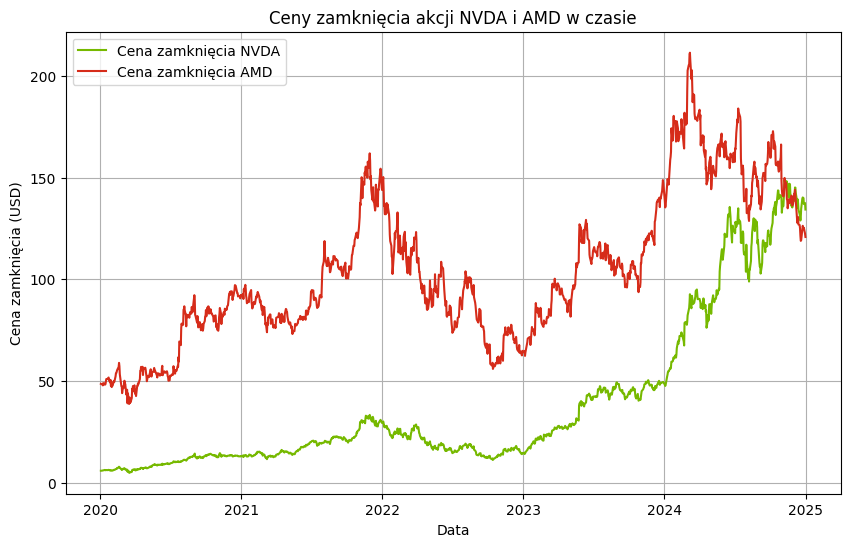

In [7]:
plt.figure(figsize=(10, 6))
plt.plot(data.index, data["Close_NVDA"], color='#76B900', label="Cena zamknięcia NVDA")
plt.plot(data.index, data["Close_AMD"], color='#D62C1A', label="Cena zamknięcia AMD")
plt.xlabel("Data")
plt.ylabel("Cena zamknięcia (USD)")
plt.title("Ceny zamknięcia akcji NVDA i AMD w czasie")
plt.legend()
plt.grid()
plt.show()

## Zróżnicowanie szeregów czasowych

In [8]:
data["diff_nvda"] = data["Close_NVDA"].diff()
data["diff_amd"] = data["Close_AMD"].diff()
data = data.dropna()

In [10]:
print(data[["diff_nvda","diff_amd"]].describe())

         diff_nvda     diff_amd
count  1256.000000  1256.000000
mean      0.102230     0.057476
std       1.698458     3.467702
min     -11.367203   -18.120010
25%      -0.374537    -1.632501
50%       0.053076    -0.024998
75%       0.489287     1.879999
max      13.286720    17.570007


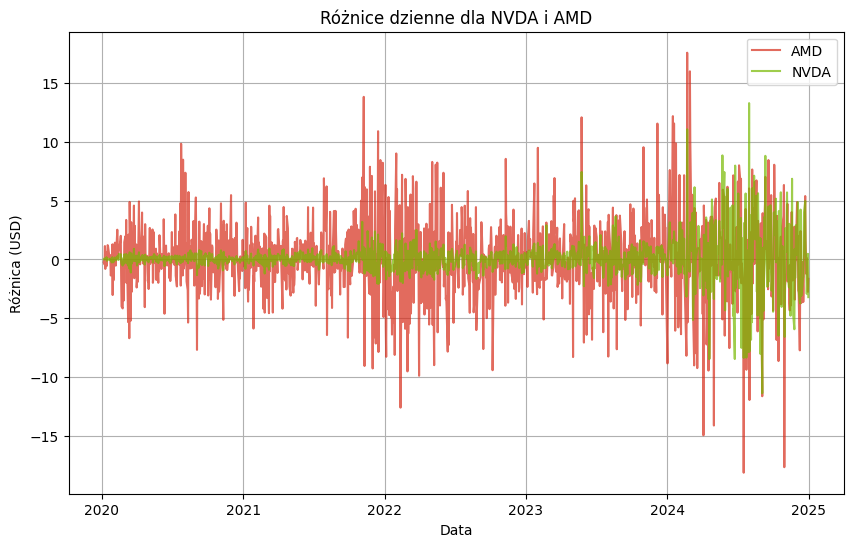

In [12]:
plt.figure(figsize=(10, 6))
plt.plot(data.index, data["diff_amd"], label="AMD", color="#D62C1A", alpha=0.7)
plt.plot(data.index, data["diff_nvda"], label="NVDA", color="#76B900", alpha=0.7)
plt.title("Różnice dzienne dla NVDA i AMD")
plt.xlabel("Data")
plt.ylabel("Różnica (USD)")
plt.legend()
plt.grid(True)
plt.show()

## Dopasowanie rozkładów

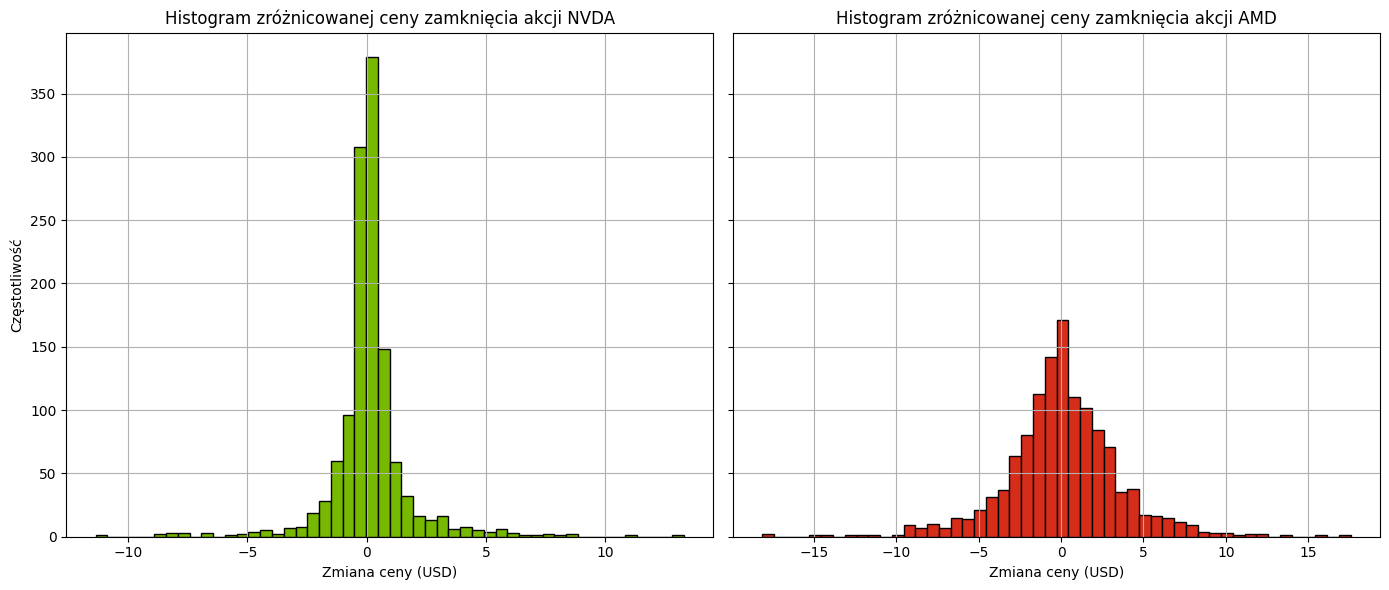

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

axes[0].hist(data["diff_nvda"], bins=50, edgecolor='k', color='#76B900')
axes[0].set_title("Histogram zróżnicowanej ceny zamknięcia akcji NVDA")
axes[0].set_xlabel("Zmiana ceny (USD)")
axes[0].set_ylabel("Częstotliwość")
axes[0].grid(True)

axes[1].hist(data["diff_amd"], bins=50, edgecolor='k', color='#D62C1A')
axes[1].set_title("Histogram zróżnicowanej ceny zamknięcia akcji AMD")
axes[1].set_xlabel("Zmiana ceny (USD)")
axes[1].grid(True)

plt.tight_layout()
plt.show()